In [148]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
model_name = 'enformer'

bin_index = [447, 448]
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]

In [150]:
cell_lines

['PC-3', 'GM12878', 'K562']

In [151]:
result_summary = {}
for cell_index, cell_line in enumerate(cell_lines):
    result_files = glob.glob(f'../results/context_swap_test/enformer/{cell_line}/*')
    df_context = pd.read_csv(f'../results/context_dependence_test/{model_name}/{cell_line}_context.csv')
    df_context['source_id'] = [p.split('/')[-1].split('.')[0] for p in df_context['path']]
    context_id = dict(zip(df_context['source_id'], df_context['context']))
    wt_preds = {}
    for i, row in df_context.iterrows():
        res = utils.read_pickle(f'../results/context_swap_test/enformer/{cell_line}/{row["source_id"]}.pickle')
        
        wt_preds[row['source_id']] = res[row['source_id']][:, bin_index, cell_index].mean()
    
    dfs = []
    for i, row in tqdm(df_context.iterrows()):
        res = utils.read_pickle(f'../results/context_swap_test/enformer/{cell_line}/{row["source_id"]}.pickle')
        swaped_preds = [[k, v[:,[447, 448], cell_index].mean()] for k, v in res.items()]
        df = pd.DataFrame(swaped_preds)
        df.columns = ['target_id', 'swapped']
        df['source_wt'] = wt_preds[row['source_id']]
        df['source_id'] = row['source_id']
        df['target_wt'] = [wt_preds[k] for k in df['target_id']]
        dfs.append(df)
    dfs = pd.concat(dfs)
    
    dfs['target_context'] = [context_id[i] for i in dfs['target_id']]
    dfs['source_context'] = [context_id[i] for i in dfs['source_id']]
    dfs['normalized'] = (dfs['swapped']) / dfs['source_wt']
    result_summary[cell_line] = dfs

342it [00:01, 226.24it/s]
351it [00:01, 219.83it/s]
481it [00:03, 153.53it/s]


In [167]:
df = dfs_by_content

In [170]:
dict(zip(list(n_obs_df.index), n_obs_df.iloc[:,0].values))

{'enhancing': 29440, 'neutral': 15744, 'silencing': 16384}

In [169]:
nobs

['n: 29440', 'n: 16384', 'n: 15744']

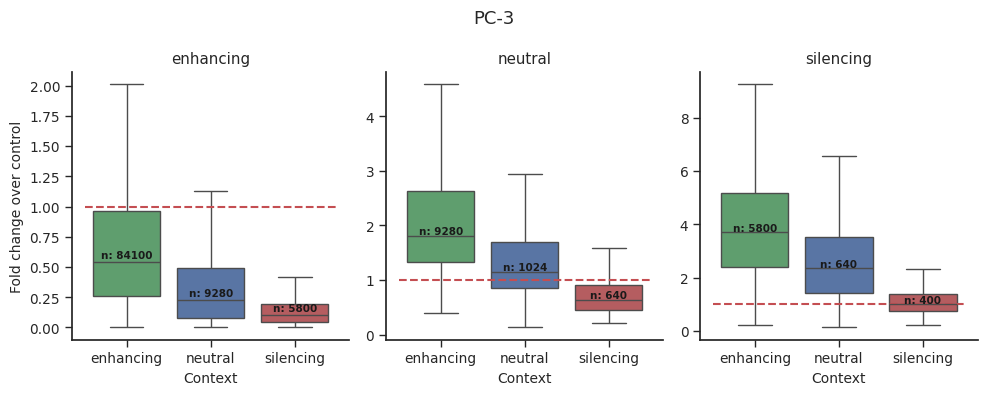

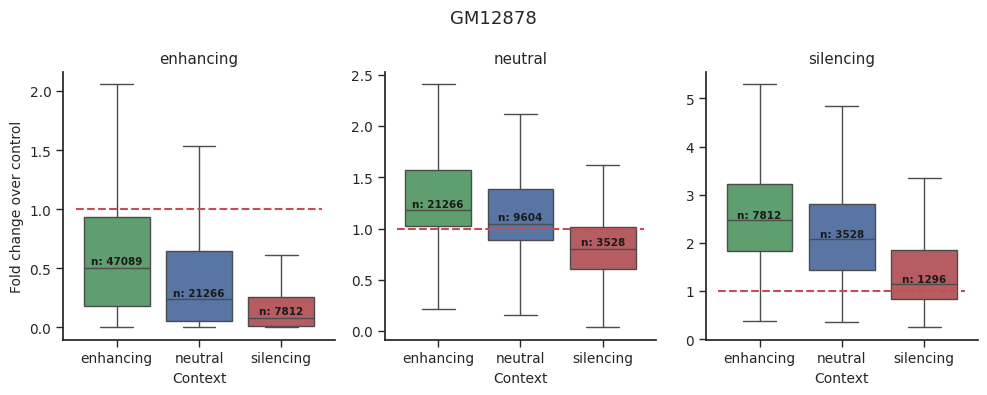

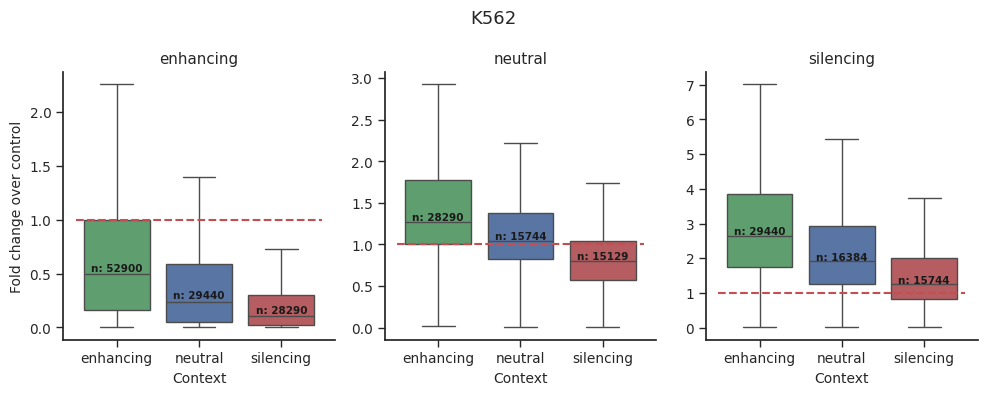

In [172]:
for cell_line, dfs in result_summary.items():    
    ylims = [2, 1.5, 7.5]
    sns.set(font_scale = .9)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 5
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 5
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    
    my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
    
    fig, axes = plt.subplots(1, 3, sharey=False, figsize=[10, 4]) 
    
    for i, (source_context, dfs_by_content) in enumerate(dfs.groupby('source_context')):
        ax= axes[i]
        sns.boxplot(x='target_context', y='normalized', data=dfs_by_content, 
                    hue='target_context', showfliers=False, palette=my_pal, ax=ax)
        ax.set_title(source_context)
        x1, x2 = ax.get_xlim()
        # ax.set_ylim(0, ylims[i])
            
        ax.hlines(1, x1, x2, color='r', linestyles='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=10)
        if i == 0:
            ax.set_ylabel('Fold change over control', fontsize=10)
        else:
            ax.set_ylabel('')
        # add number of observations in each box
        medians = dfs_by_content.groupby(['target_context'])['normalized'].median().values
        nobs = dfs_by_content['target_context'].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = ["n: " + i for i in nobs]

        # Add it to the plot
        pos = range(len(nobs))
        for tick,label in zip(pos,ax.get_xticklabels()):
            ax.text(pos[tick],
                    medians[tick] + 0.03,
                    nobs[tick],
                    horizontalalignment='center',
                    size='x-small',
                    color='k',
                    weight='semibold')
        
    plt.suptitle(cell_line)
    plt.tight_layout()